# QGS model: Atmospheric model with heat exchange
## Li et al. 2017 model version
This model version is a simple 2-layer channel QG atmosphere truncated at wavenumber 2 on a beta-plane with a simple orography (a montain and a valley) , with a radiative and heat exchanges scheme inspired by the MAOOAM model.

More detail can be found in the articles:
* Li, D., He, Y., Huang, J., Bi, L., & Ding, L. (2018). *Multiple equilibria in a land–atmosphere coupled system.* Journal of Meteorological Research, **32**(6), 950-973.
[doi:10.1007/s13351-018-8012-y](https://doi.org/10.1007/s13351-018-8012-y)
* De Cruz, L., Demaeyer, J. and Vannitsem, S. (2016). *The Modular Arbitrary-Order Ocean-Atmosphere Model: MAOOAM v1.0*, Geosci. Model Dev., **9**, 2793-2808. [doi:10.5194/gmd-9-2793-2016](https://doi.org/10.5194/gmd-9-2793-2016)

or in the documentation.

## Modules import
First, setting the path and loading of some modules

In [1]:
import sys, os

In [2]:
sys.path.extend([os.path.abspath('../')])

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [4]:
from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Times'],'size':14})

Initializing the random number generator (for reproducibility). -- Disable if needed.

In [5]:
np.random.seed(210217)

Importing the model's modules

In [6]:
from qgs.params.params import QgParams
from qgs.integrators.integrator import RungeKuttaIntegrator, RungeKuttaTglsIntegrator
from qgs.functions.tendencies import create_tendencies
from qgs.plotting.util import std_plot

and diagnostics

In [7]:
from qgs.diagnostics.streamfunctions import MiddleAtmosphericStreamfunctionDiagnostic
from qgs.diagnostics.variables import VariablesDiagnostic
from qgs.diagnostics.multi import MultiDiagnostic

## Systems definition
General parameters. I am selecting standard parameters for the runs below, not sure if this is what Robin is using

In [8]:
# Time parameters
dt = 0.1
# Saving the model state n steps
write_steps = 5

number_of_trajectories = 1
number_of_perturbed_trajectories = 10

The other parameters can come from model1.pickle that Robin prepared:

In [9]:
import pickle
# loading the model
with open('model1.pickle', "rb") as file:
    model = pickle.load(file)

f = model['f']
Df = model['Df']
model_parameters = model['parameters']
# Printing the model's parameters
model_parameters.print_params()

Qgs v0.2.5 parameters summary

General Parameters:
'time_unit': days,
'rr': 287.058  [J][kg^-1][K^-1]  (gas constant of dry air),
'sb': 5.67e-08  [J][m^-2][s^-1][K^-4]  (Stefan-Boltzmann constant),

Scale Parameters:
'scale': 5000000.0  [m]  (characteristic space scale (L*pi)),
'f0': 0.0001032  [s^-1]  (Coriolis parameter at the middle of the domain),
'n': 0.353    (aspect ratio (n = 2 L_y / L_x)),
'rra': 6370000.0  [m]  (earth radius),
'phi0_npi': 0.25    (latitude expressed in fraction of pi),
'deltap': 50000.0  [Pa]  (pressure difference between the two atmospheric layers),

Atmospheric Parameters:
'kd': 0.1  [nondim]  (atmosphere bottom friction coefficient),
'kdp': 0.01  [nondim]  (atmosphere internal friction coefficient),
'sigma': 0.2  [nondim]  (static stability of the atmosphere),

Atmospheric Temperature Parameters:
'gamma': 10000000.0  [J][m^-2][K^-1]  (specific heat capacity of the atmosphere),
'C[1]': 112.0  [W][m^-2]  (spectral component 1 of the short-wave radiation of t

/home/scratch01/gmiloshe/tests/qgs/qgs/params/parameter.py:106: UserWarning: Parameter configured to perform dimensional conversion but without specifying a ScaleParams object: Conversion disabled!
  warnings.warn("Parameter configured to perform dimensional conversion " +


Why did Robin choose n = 0.353? Otherwise the setup is similar to ground_heat.ipynb but with more spectral components. It is not clear to me if we need many spectral components. The typical setup with fewer components is usually enough to provide some realism. 

Parameters that are different:
* Atmospheric Temperature parameters
    * 'C[1]' : 122 [W][m^-2] instead of 99 [W][m^-2]: (spectral component 1 of the short-wave radiation of the atmosphere), other C's are zero
    * 'hlambda': 20  [W][m^-2][K^-1] instead of 10 [W][m^-2][K^-1] (sensible+turbulent heat exchange between ocean and atmosphere),
* Ground Parameters:
    * 'hk[2]': 0.4 instead of 0.2    (spectral components 2 of the orography), other h'k are zero
* Ground Temperature Parameters:
    * 'gamma': 200000000  [J][m^-2][K^-1] instead of 16000000  (specific heat capacity of the ground),
    * 'C[1]': 280.0  [W][m^-2]  (spectral component 1 of the short-wave radiation of the ground), other C parameters are zero

Below we can also investigate what fields that are actually used 

In [10]:
model_parameters.latex_var_string

['{\\psi_{\\rm a,1}}',
 '{\\psi_{\\rm a,2}}',
 '{\\psi_{\\rm a,3}}',
 '{\\psi_{\\rm a,4}}',
 '{\\psi_{\\rm a,5}}',
 '{\\psi_{\\rm a,6}}',
 '{\\psi_{\\rm a,7}}',
 '{\\psi_{\\rm a,8}}',
 '{\\psi_{\\rm a,9}}',
 '{\\psi_{\\rm a,10}}',
 '{\\psi_{\\rm a,11}}',
 '{\\psi_{\\rm a,12}}',
 '{\\psi_{\\rm a,13}}',
 '{\\psi_{\\rm a,14}}',
 '{\\psi_{\\rm a,15}}',
 '{\\psi_{\\rm a,16}}',
 '{\\psi_{\\rm a,17}}',
 '{\\psi_{\\rm a,18}}',
 '{\\psi_{\\rm a,19}}',
 '{\\psi_{\\rm a,20}}',
 '{\\psi_{\\rm a,21}}',
 '{\\psi_{\\rm a,22}}',
 '{\\psi_{\\rm a,23}}',
 '{\\psi_{\\rm a,24}}',
 '{\\psi_{\\rm a,25}}',
 '{\\psi_{\\rm a,26}}',
 '{\\psi_{\\rm a,27}}',
 '{\\psi_{\\rm a,28}}',
 '{\\psi_{\\rm a,29}}',
 '{\\psi_{\\rm a,30}}',
 '{\\psi_{\\rm a,31}}',
 '{\\psi_{\\rm a,32}}',
 '{\\psi_{\\rm a,33}}',
 '{\\psi_{\\rm a,34}}',
 '{\\psi_{\\rm a,35}}',
 '{\\psi_{\\rm a,36}}',
 '{\\theta_{\\rm a,1}}',
 '{\\theta_{\\rm a,2}}',
 '{\\theta_{\\rm a,3}}',
 '{\\theta_{\\rm a,4}}',
 '{\\theta_{\\rm a,5}}',
 '{\\theta_{\\rm a,6

Creating the tendencies function

In [11]:
%%time
f, Df = create_tendencies(model_parameters)

CPU times: user 3min 26s, sys: 3.32 s, total: 3min 29s
Wall time: 3min 26s


## Time integration
Defining an integrator

In [12]:
integrator = RungeKuttaIntegrator()
integrator.set_func(f)

Start on a random initial condition and integrate over a transient time to obtain an initial condition on the attractors. I kept the standard time that is typically used in other runs, so not sure if it perfectly adapted...

In [13]:
%%time
ic = np.random.rand(model_parameters.ndim)*0.1
integrator.integrate(0., 200000., dt, ic=ic, write_steps=0)
time, ic = integrator.get_trajectories()

CPU times: user 25.7 ms, sys: 32.1 ms, total: 57.8 ms
Wall time: 2min 9s


Now integrate to obtain a trajectory on the attractor

In [14]:
%%time
integrator.integrate(0., 100000., dt, ic=ic, write_steps=write_steps)
reference_time, reference_traj = integrator.get_trajectories()

CPU times: user 264 ms, sys: 465 ms, total: 729 ms
Wall time: 1min 3s


We can visualize the trajectories of individual harmonics in 3D

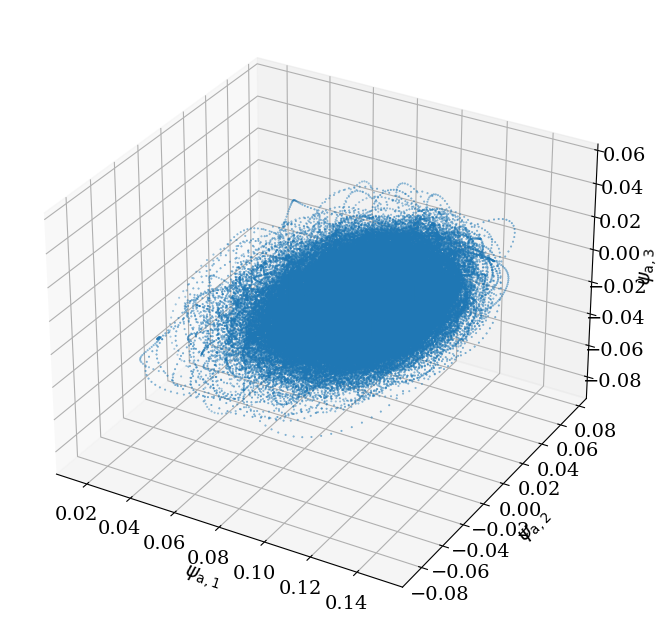

In [15]:
varx = 0
vary = 1
varz = 2

fig = plt.figure(figsize=(10, 8))
axi = fig.add_subplot(111, projection='3d')

axi.scatter(reference_traj[varx], reference_traj[vary], reference_traj[varz], s=0.2);

axi.set_xlabel('$'+model_parameters.latex_var_string[varx]+'$')
axi.set_ylabel('$'+model_parameters.latex_var_string[vary]+'$')
axi.set_zlabel('$'+model_parameters.latex_var_string[varz]+'$');

Also in 2D

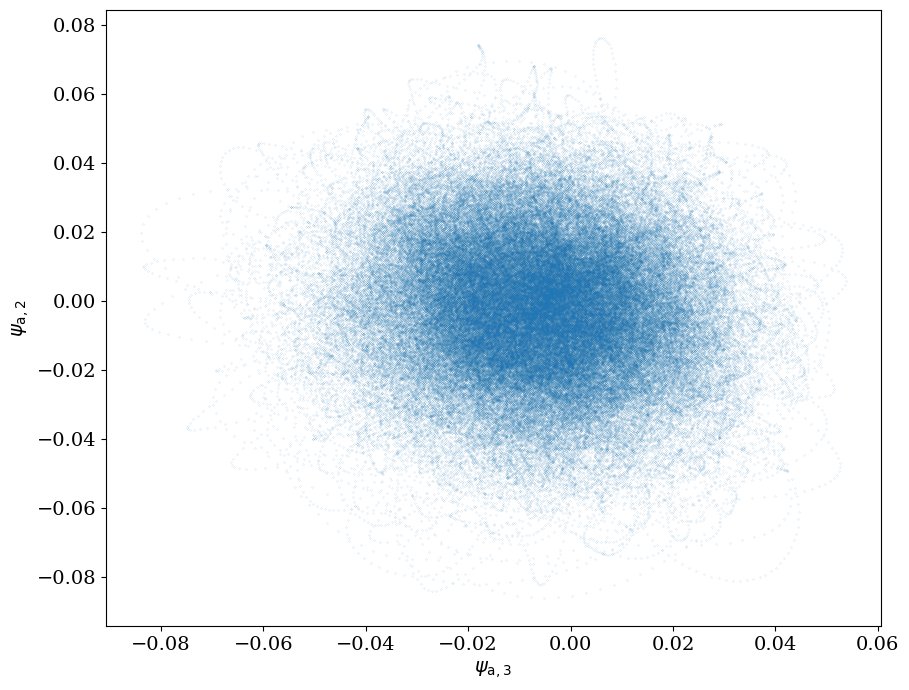

In [16]:
varx = 2
vary = 1
plt.figure(figsize=(10, 8))

plt.plot(reference_traj[varx], reference_traj[vary], marker='o', ms=0.07, ls='')

plt.xlabel('$'+model_parameters.latex_var_string[varx]+'$')
plt.ylabel('$'+model_parameters.latex_var_string[vary]+'$');

And even 1D

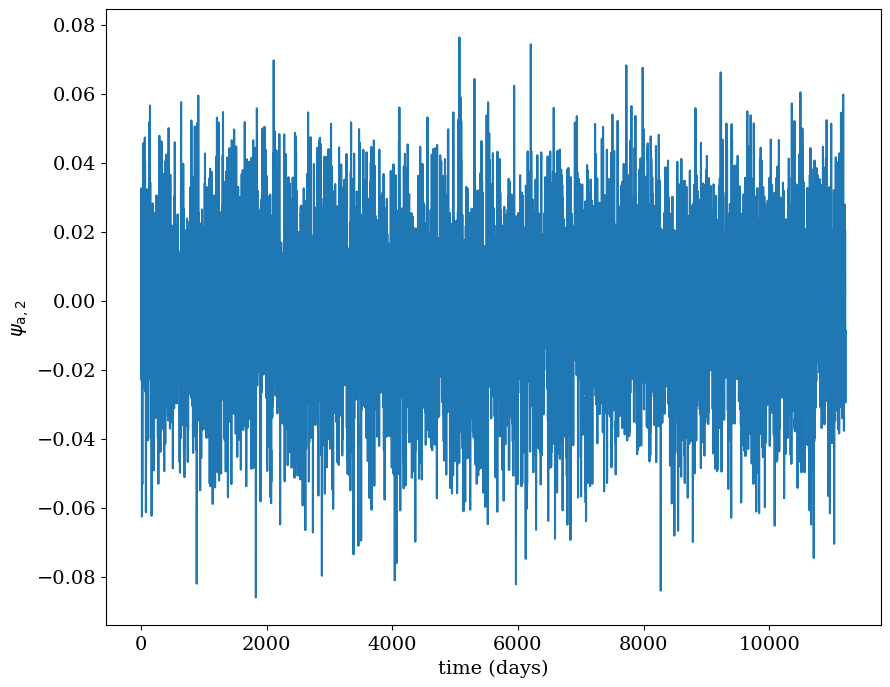

In [17]:
var = 1
plt.figure(figsize=(10, 8))

plt.plot(model_parameters.dimensional_time*reference_time, reference_traj[var])

plt.xlabel('time (days)')
plt.ylabel('$'+model_parameters.latex_var_string[var]+'$');

## Initial condition sensitivity analysis example
Instantiating a tangent linear integrator with the model tendencies

In [18]:
tgls_integrator = RungeKuttaTglsIntegrator()
tgls_integrator.set_func(f, Df)

Integrating with slightly perturbed initial conditions

In [19]:
%%time 
tangent_ic = 0.0001*np.random.randn(number_of_perturbed_trajectories, model_parameters.ndim)
tgls_integrator.integrate(0., 130., dt=dt, write_steps=write_steps, ic=ic, tg_ic=tangent_ic)

CPU times: user 11.4 ms, sys: 18.9 ms, total: 30.4 ms
Wall time: 6.55 s


Obtaining the perturbed trajectories

In [20]:
time, traj, delta = tgls_integrator.get_trajectories()
pert_traj = traj + delta

Trajectories plot

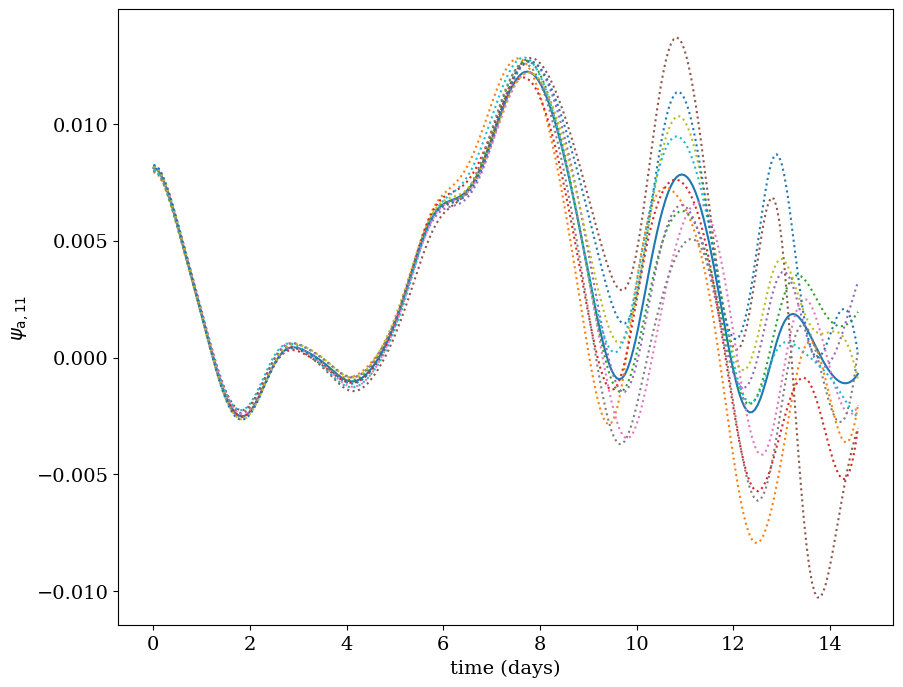

In [21]:
var = 10
plt.figure(figsize=(10, 8))

plt.plot(model_parameters.dimensional_time*time, traj[var])
plt.plot(model_parameters.dimensional_time*time, pert_traj[:,var].T, ls=':')

ax = plt.gca()

plt.xlabel('time (days)')
plt.ylabel('$'+model_parameters.latex_var_string[var]+'$');

Mean and standard deviation

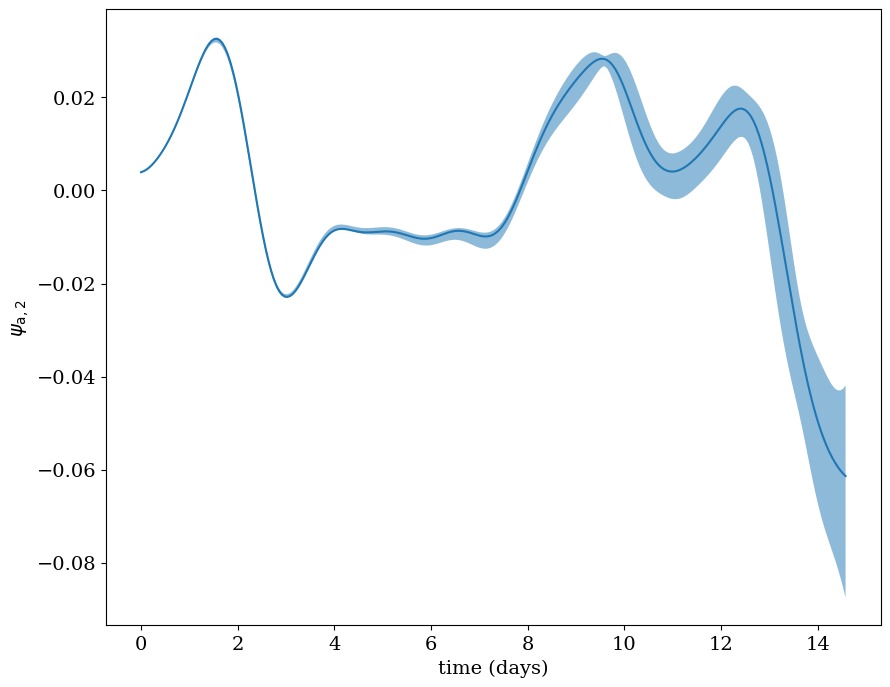

In [22]:
var = 1
plt.figure(figsize=(10, 8))

plt.plot(model_parameters.dimensional_time*time, traj[var])

ax = plt.gca()
std_plot(model_parameters.dimensional_time*time, np.mean(pert_traj[:,var], axis=0), np.sqrt(np.var(pert_traj[:, var], axis=0)), ax=ax, alpha=0.5)

plt.xlabel('time (days)')
plt.ylabel('$'+model_parameters.latex_var_string[var]+'$');

## Showing the resulting fields (animation)

This is an advanced feature showing the time evolution of diagnostic of the model. It shows simultaneously a scatter plot of the variable $\psi_2$ and $\psi_3$, and the geopotential height field at 500 hPa over the orographic height. Please read the documentation for more information.

Creating the diagnostics:
* For the 500hPa geopotential height:

In [23]:
psi = MiddleAtmosphericStreamfunctionDiagnostic(model_parameters, geopotential=True)

* For the nondimensional variables $\psi_2$ and $\psi_3$:

In [24]:
variable_nondim = VariablesDiagnostic([2, 1], model_parameters, False)

setting also the background

In [25]:
background = VariablesDiagnostic([2, 1], model_parameters, False)
background.set_data(reference_time, reference_traj)

Creating a multi diagnostic with both:

In [26]:
m = MultiDiagnostic(1,2)
m.add_diagnostic(variable_nondim,
                 diagnostic_kwargs={'show_time': False, 'background': background},
                 plot_kwargs={'ms': 0.2})
m.add_diagnostic(psi,
                 diagnostic_kwargs={'style': 'contour', 'contour_labels': False},
                 plot_kwargs={'colors': 'k'})
m.set_data(time, traj)

and show an interactive animation:

In [31]:
rc('font',**{'family':'serif','sans-serif':['Times'],'size':12})
m.animate(figsize=(20,6))

interactive(children=(IntSlider(value=130, description='time_index', max=260), Output()), _dom_classes=('widge…

We can also quickly plot the snapshot of geopotential at a given time

(<AxesSubplot:title={'center':'Atmospheric 500hPa geopotential height (in m) at 1.40 days'}, xlabel='$x$', ylabel='$y$'>,
 <matplotlib.colorbar.Colorbar at 0x2aff13263b50>)

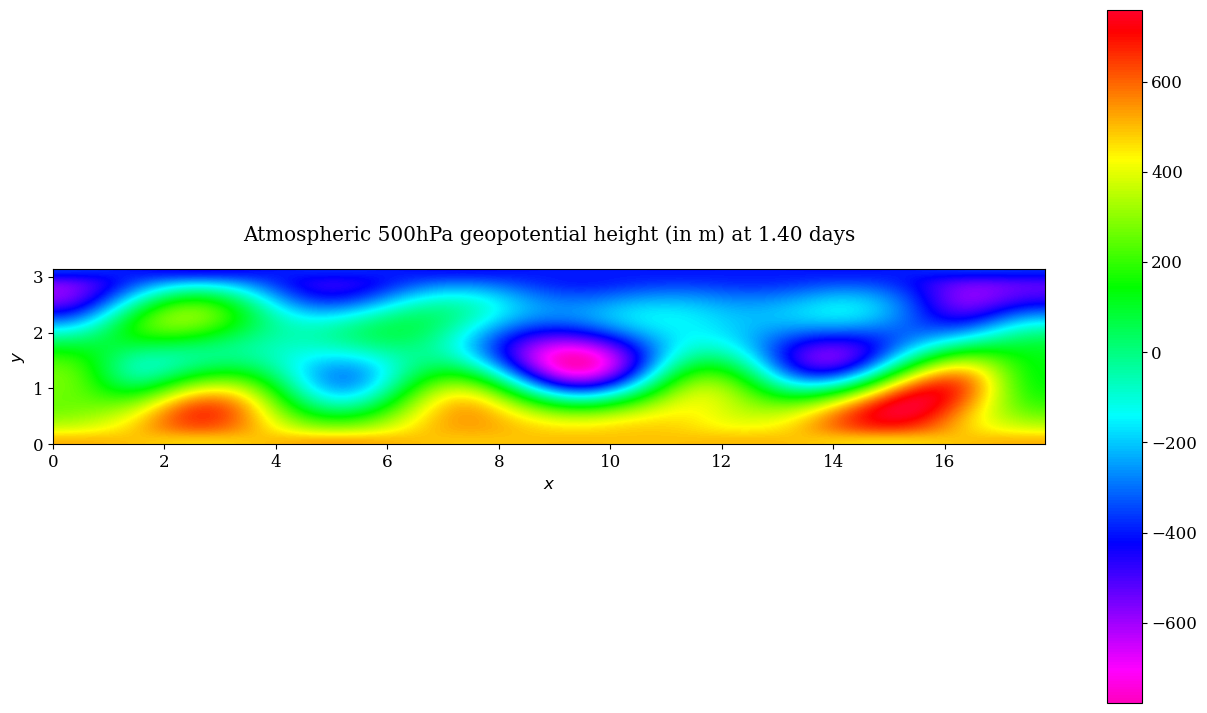

In [29]:
psi.plot(25)

Or make a short movie

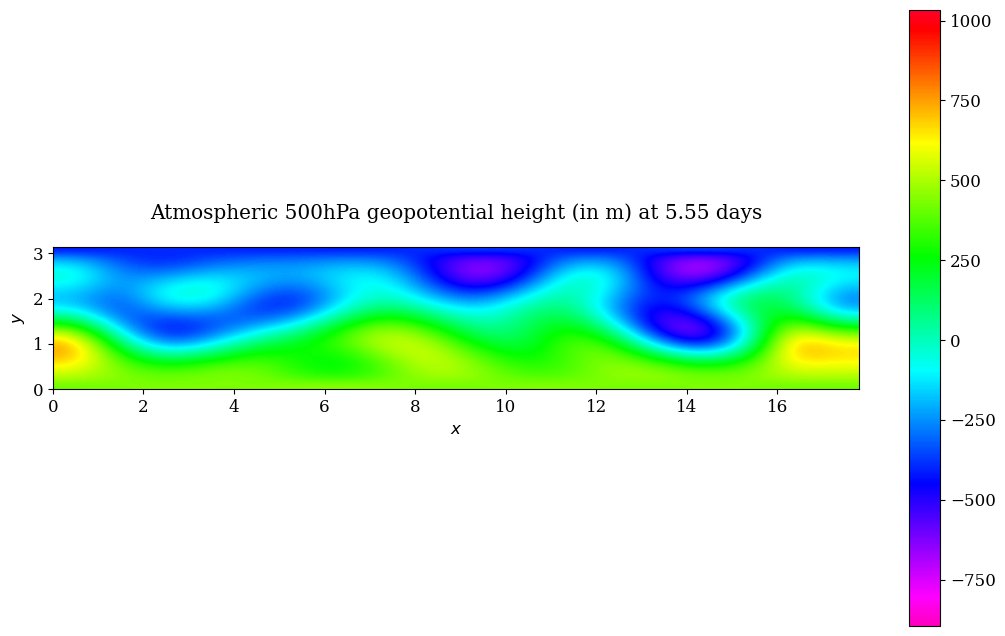

In [30]:
psi.movie(figsize=(13,8), anim_kwargs={'interval': 100, 'frames':100})

In [33]:
from qgs.diagnostics.variables import GeopotentialHeightDifferenceDiagnostic

For the geopotential height difference between North and South:

In [34]:
geopot_dim = GeopotentialHeightDifferenceDiagnostic([[[np.pi/model_parameters.scale_params.n, np.pi/4], [np.pi/model_parameters.scale_params.n, 3*np.pi/4]]],
                                                    model_parameters, True)


Creating a multi diagnostic for just this one variable. Maybe this is not optimal?

In [46]:
m = MultiDiagnostic(1,1)
m.add_diagnostic(geopot_dim, diagnostic_kwargs={'style':'timeserie'})
m.set_data(time, traj)

Making a movie

CPU times: user 34.3 ms, sys: 7.89 ms, total: 42.2 ms
Wall time: 35.8 ms


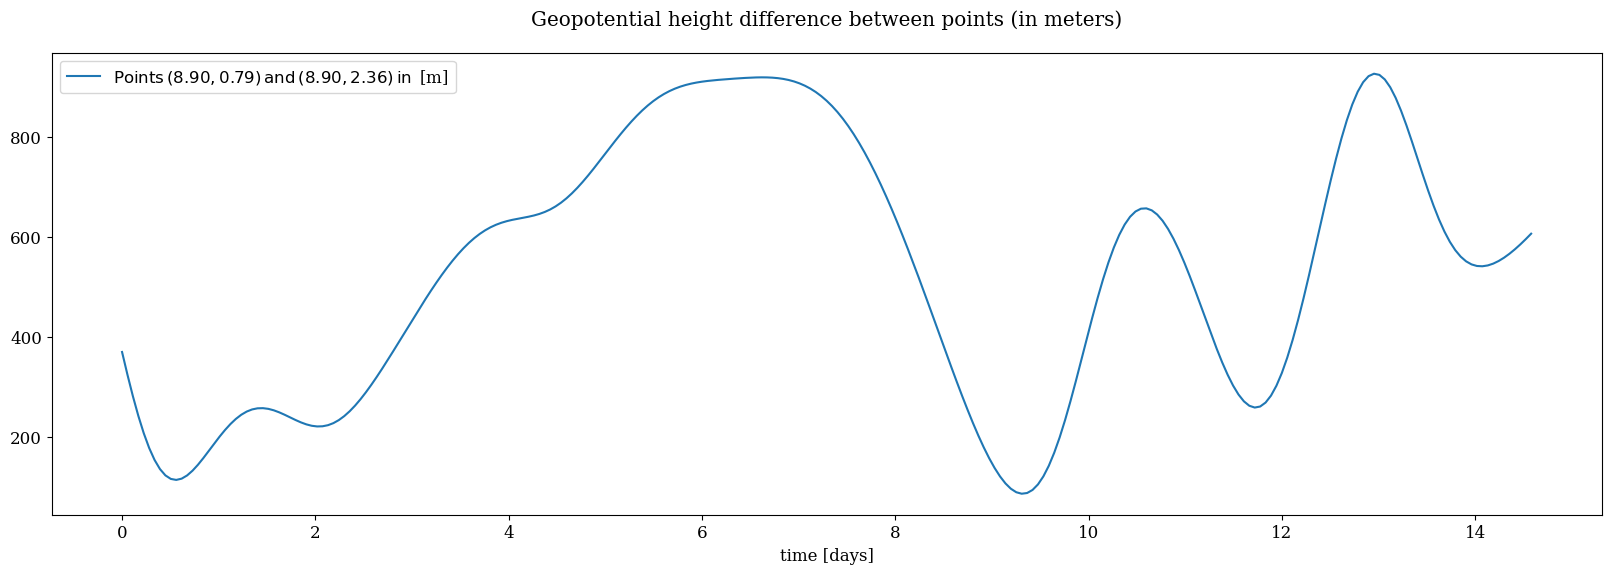

In [49]:
%%time
rc('font',**{'family':'serif','sans-serif':['Times'],'size':12})
m.plot(figsize=(20,6), time_index=0)

In [41]:
len(reference_time), len(reference_traj)

(200001, 108)